In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt
from pandas import read_csv
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.callbacks import TensorBoard
from time import time

In [3]:
# %matplotlib gtk

In [27]:
def create_dataset(dataset, look_back = 1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), :]
        dataX.append(a)
        dataY.append(dataset[i + look_back, :])
    return np.array(dataX), np.array(dataY)

In [28]:
dataframe = read_csv('./Data/flood_train.csv', skipinitialspace = True, squeeze = True)
print(dataframe.head())

        datetime  rainfall  waterlevel
0  1/1/2013 0:10       0.0        0.21
1  1/1/2013 0:21       0.0        0.21
2  1/1/2013 0:30       0.0        0.40
3  1/1/2013 1:30       0.0        0.49
4  1/1/2013 1:40       0.0        0.59


In [29]:
dataframe.shape

(109197, 3)

In [30]:
data = np.array(dataframe)
data = data[:, 1:]

In [31]:
data[:5]

array([[0.0, 0.21],
       [0.0, 0.21],
       [0.0, 0.4],
       [0.0, 0.49],
       [0.0, 0.59]], dtype=object)

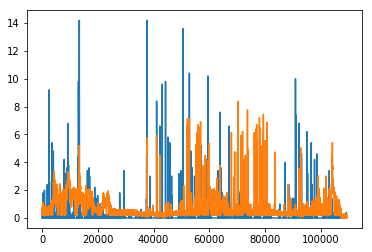

In [32]:
plt.plot(data)
plt.show()

In [33]:
# data = data.reshape((data.shape[0], 1))
data.shape

(109197, 2)

In [34]:
data = data.astype('float64')

scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)
print(data[:5])

[[0.         0.02508961]
 [0.         0.02508961]
 [0.         0.04778973]
 [0.         0.05854241]
 [0.         0.07048984]]


In [35]:
split = 0.67
train_size = int(len(data)*split)
test_size = len(data)-train_size
train = data[0:train_size,:]
test = data[train_size:len(data),:]
print(train.shape)
print(test.shape)

(73161, 2)
(36036, 2)


In [36]:
look_back = 10
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
print(trainX.shape)
# print(trainY[:5])

(73150, 10, 2)


In [37]:
trainY[:5]

array([[0.        , 0.0609319 ],
       [0.        , 0.06332139],
       [0.        , 0.06810036],
       [0.        , 0.0692951 ],
       [0.        , 0.06810036]])

In [38]:
# trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
# testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [39]:
units = 100
drop = 0.2
epoch = 1

model = Sequential()
model.add(LSTM(units, input_shape=(look_back, 2)))
model.add(Dropout(drop))
model.add(Dense(2))
# model.compile(loss='mean_squared_error', optimizer='adam')
model.compile(loss='mean_squared_error', optimizer='nadam')
# model.summary()
tensorboard = TensorBoard(log_dir="logs/{}".format(time()))
model.fit(trainX, trainY, epochs=epoch, batch_size=1, verbose=1, callbacks=[tensorboard])


Epoch 1/1
73150/73150 [==============================] - 822s 11ms/step - loss: 3.1084e-04


In [40]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [42]:
testPredict.shape

(36025, 2)

In [43]:
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform(trainY)
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(testY)

In [44]:
trainScore = math.sqrt(mean_squared_error(trainY, trainPredict))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY, testPredict))
print('Test Score: %.2f RMSE' % (testScore))


Train Score: 0.16 RMSE
Test Score: 0.14 RMSE


In [45]:
trainPredictPlot = np.empty_like(data)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

testPredictPlot = np.empty_like(data)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(data)-1, :] = testPredict


In [46]:
# print(data.shape)
# print(train.shape)
# print(test.shape)
# print(trainPredict.shape)
# print(testPredict.shape)

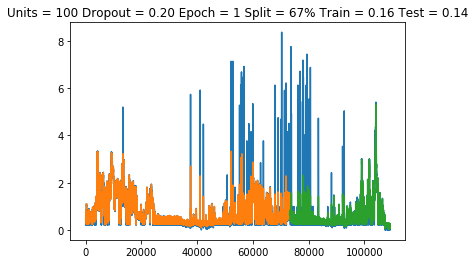

In [47]:
col = 1
plt.plot(scaler.inverse_transform(data)[:,col])
plt.plot(trainPredictPlot[:,col])
plt.plot(testPredictPlot[:,col])

# plt.plot(scaler.inverse_transform(data))
# plt.plot(trainPredictPlot)
# plt.plot(testPredictPlot)
plt.title('Units = %d Dropout = %.2f Epoch = %d Split = %d%% Train = %.2f Test = %.2f' % 
          (units, drop, epoch, split*100, trainScore, testScore))
plt.show()

In [48]:
testActual = read_csv('./Data/flood_test.csv')
testActual.head()

,datetime,waterlevel
0,7/4/2013 21:30,0.27
1,7/4/2013 21:40,0.26
2,7/4/2013 21:50,0.27
3,7/4/2013 22:00,0.28
4,7/4/2013 22:10,0.28


In [49]:
data = np.array(testActual['waterlevel'])
data = data.reshape((len(data), 1))
data = data.astype('float64')

scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)
print(data[:5])

[[0.04770318]
 [0.0459364 ]
 [0.04770318]
 [0.04946996]
 [0.04946996]]


In [50]:
data = np.hstack((data, np.zeros(data.shape)))

In [51]:
data[: 5]

array([[0.04770318, 0.        ],
       [0.0459364 , 0.        ],
       [0.04770318, 0.        ],
       [0.04946996, 0.        ],
       [0.04946996, 0.        ]])

In [53]:
look_back = 10
predictX, predictY = create_dataset(data, look_back)
predict = model.predict(predictX)

In [54]:
# for i in range(len(predictX)-3):
#     Y = model.predict(predictX[i:i+1, :, :])
#     predictX[i+1, 2] = Y
#     predictX[i+2, 1] = Y
#     predictX[i+3, 0] = Y
#     predictY[i, :] = Y
# model.predict(predictX[0:1, :, :])
# predictX[0:1, :, :].shape
# print(predictY[5, :])
# predictY[5, :] = np.array([1, 2])
# print(predictY[5, :])
# temp = predictY
# print(temp.shape)
# temp = np.append(temp, [1, 1])
# print(temp.shape)

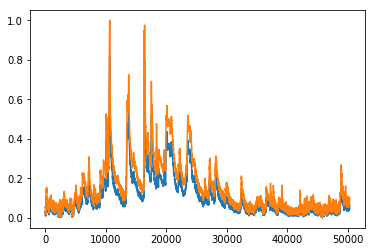

In [55]:
col = 0
plt.plot(predict[:, col]) # Blue
plt.plot(predictY[:, col]) # Orange
plt.show()